In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import os


pd.options.display.max_columns = None

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
 
import pandas as pd
import numpy as np
 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from numpy import absolute
from sklearn.model_selection import (RepeatedKFold, cross_val_score,
                              train_test_split, GridSearchCV,GridSearchCV)


from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    LabelEncoder,
    OneHotEncoder,
)

from sklearn import set_config
set_config(display='diagram')


In [3]:
# Загрузим всё
train = pd.read_csv('track_1/train.csv') # main_df
print(train.day.unique())  #Дни больше чем 30 !!!!
train.head()   #Отсчет дней с 21 апреля по 3 июня происходит затор льда. 

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44  0]


,year,station_id,day,ice_jam
0,2000,3019,1,0.0
1,2000,3019,2,0.0
2,2000,3019,3,0.0
3,2000,3019,4,0.0
4,2000,3019,5,0.0


In [4]:
# города
# Киренск, посёлок городского типа Витим, посёлок городского типа Пеледуй, село Крестовский 
# Лесоуùасток, город Ленск, город Олёкминск, город Покровск, город Якутск, село Батамай, 
# посёлок городского типа Сангар

<p style="align: center;"><img align=center src="Images/post_map.PNG"  width=900></p>
<h3 style="text-align: center;"><b>Карта метеостанций и гидропостов</b></h3>


In [5]:
# # Загрузим всё
# train = pd.read_csv('1_track_extra_train/hydro_1day.csv') # main_df
# print(train.day.unique())  #Дни больше чем 30 !!!!
# train.head()   #Отсчет дней с 21 апреля по 3 июня происходит затор льда. 

In [6]:
# # Загрузим всё
# train = pd.read_csv('track_1/hydro_1day.csv') # main_df
# print(train.day.unique())  #Дни больше чем 30 !!!!
# train.head()   #Отсчет дней с 21 апреля по 3 июня происходит затор льда. 

In [7]:
# Путь к директории с данными

data_dir_new = '1_track_extra_train/'
os.listdir(data_dir_new)

['hydro_1day.csv', 'meteo_1day.csv', 'meteo_1month.csv', 'meteo_3hours.csv']

In [8]:
# Путь к директории с данными

data_dir = './track_1/'
os.listdir(data_dir)

['hydro_1day.csv',
 'hydro_coord.csv',
 'ice_saw.csv',
 'meteo_1day.csv',
 'meteo_1month.csv',
 'meteo_3hours.csv',
 'meteo_coord.csv',
 'reference_horiz_visib.csv',
 'reference_water_codes.csv',
 'test.csv',
 'train.csv']

# Train + Test

In [9]:
# Загрузим всё
train = pd.read_csv(data_dir + 'train.csv') # main_df
print(train.day.unique())  #Дни больше чем 30 !!!!
train.head()   #Отсчет дней с 21 апреля по 3 июня происходит затор льда. 

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44  0]


,year,station_id,day,ice_jam
0,2000,3019,1,0.0
1,2000,3019,2,0.0
2,2000,3019,3,0.0
3,2000,3019,4,0.0
4,2000,3019,5,0.0


In [10]:
# Загрузим всё
test = pd.read_csv(data_dir + 'test.csv') # main_df
print(test.day.unique())  #Дни больше чем 30 !!!!
test.head()   #Отсчет дней с 21 апреля по 3 июня происходит затор льда. 

test.columns

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


Index(['year', 'station_id', 'day', 'ice_jam'], dtype='object')

In [11]:
# Подтянем ближайшую к гидростанции метеостанцию

from geopy.distance import geodesic
import re

def merge_coord(df):
    df['lat_long'] = df[['lat', 'lon']].apply(tuple, axis=1)
    return df

def stat_km(point, stat_list):
    stations_list=stat_list
    lst=[]
    if pd.isnull(point):
        lst.append(np.nan)
    else:
        for i in stations_list['lat_long']:
            x=geodesic(point, i).km
            lst.append(x)
            stations_list['dist']=pd.DataFrame(lst)
        y=stations_list['station_id'][stations_list['dist'] == stations_list['dist'].min()]
        y=y.to_string()
        y=re.sub("^[0-9]+", "", y)
        y=re.sub(" +", "", y)
        return int(y)


# Метео

In [12]:
meteo_coord = pd.read_csv(data_dir + 'meteo_coord.csv')  # mc
meteo_coord.drop(['name'], axis=1,inplace=True)


# Гидро
hydro_coord = pd.read_csv(data_dir + 'hydro_coord.csv') # hc
hydro_coord.drop(columns = ['name'], inplace=True)


hydro_coord = merge_coord(hydro_coord)
meteo_coord = merge_coord(meteo_coord)
hydro_coord['met_station_id'] = meteo_coord.lat_long.apply(lambda x: stat_km(x, meteo_coord))


hydro_coord.rename(columns = {"station_id":'hyd_station_id'}, inplace=True)
meteo_coord.rename(columns = {"station_id":'met_station_id'}, inplace=True)


meteo_1day = pd.read_csv(data_dir_new + 'meteo_1day.csv')  #mld
meteo_1day.rename(columns = {"station_id":'met_station_id'}, inplace=True)
# meteo_1day.drop(['date'], inplace=True, axis=1)
print(meteo_1day.shape)
# print(meteo_1day.columns)
#meteo_1day = meteo_coord.merge(meteo_1day, on=['met_station_id'], how='left')

meteo_1month = pd.read_csv(data_dir_new + 'meteo_1month.csv')  #mlm
meteo_1month.rename(columns = {"station_id":'met_station_id'}, inplace=True)
meteo_1month = meteo_coord.merge(meteo_1month, on=['met_station_id'], how='left')
#meteo_1month.drop(['date'], inplace=True, axis=1)
# print(meteo_1month.shape)
# print(meteo_1month.columns)
# meteo_1month.head(2)


print(meteo_1month.shape)
# meteo_all = meteo_1day.merge(meteo_1month, on=['met_station_id', 'year', 'month'], 
#                 how='left')
# meteo_all.rename(columns = {"date_x":"date_1day", "date_y":"date_1month", "day_x":"day","day_y":"day_1month"}, inplace=True)

meteo_all = meteo_1month.copy()
#TODOs исправить


# meteo_all.fillna(0, inpalce=True) # Закодировать наличие пропуска в толшине воды/льда
print(meteo_all.shape)
meteo_all.info()

(346130, 48)
(10926, 17)
(10926, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10926 entries, 0 to 10925
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   met_station_id                  10926 non-null  int64  
 1   lat                             10926 non-null  float64
 2   lon                             10926 non-null  float64
 3   z                               10926 non-null  float64
 4   lat_long                        10926 non-null  object 
 5   dist                            10926 non-null  float64
 6   year                            10926 non-null  int64  
 7   month                           10926 non-null  int64  
 8   data_qual                       8801 non-null   float64
 9   precipitation_observed          8801 non-null   float64
 10  precipitation_corrected         8801 non-null   float64
 11  precipitation_corrected_liquid  8801 non-null   float64


In [13]:
#TODOs добавить инфу из meteo_3hours 

In [14]:
# refer_horiz_visib = pd.read_csv(data_dir + 'reference_horiz_visib.csv') #rhv
# refer_horiz_visib.head(2)

# Гидро

In [15]:
# # Гидро
# hydro_coord = pd.read_csv(data_dir + 'hydro_coord.csv') # hc
# hydro_coord.drop(columns = ['name'], inplace=True)
# hydro_coord.rename(columns = {"station_id":'hyd_station_id'}, inplace=True)

print('hydro_coord', hydro_coord.shape)
#print(hydro_coord.columns)
# hydro_coord.head(3)


hydro_1day = pd.read_csv(data_dir_new + 'hydro_1day.csv',  parse_dates=['date'])  # hld             
hydro_1day.rename(columns = {"station_id":'hyd_station_id'}, inplace=True)
#hydro_1day.drop('date', inplace=True, axis=1)



def check_is_none(x):  #Заметим что фичу не надо категоризировать!
    if x is None: return 1
    else: return 0

    
    
hydro_1day['ice_thickness_is_none'] =hydro_1day['ice_thickness'].apply(check_is_none)
hydro_1day['ice_thickness'].fillna(hydro_1day['ice_thickness'].mean(), inplace=True)

hydro_1day['snow_height_is_none'] =hydro_1day['snow_height'].apply(check_is_none)
hydro_1day['snow_height'].fillna(hydro_1day['snow_height'].mean(), inplace=True)


print('hydro_1day размер',hydro_1day.shape)
print(hydro_1day.columns)

hydro_coord (27, 8)
hydro_1day размер (234138, 16)
Index(['year', 'hyd_station_id', 'month', 'day', 'date', 'stage_avg',
       'stage_min', 'stage_max', 'temp', 'water_code', 'ice_thickness',
       'snow_height', 'place', 'discharge', 'ice_thickness_is_none',
       'snow_height_is_none'],
      dtype='object')


In [16]:
hydro_1day = hydro_1day.groupby(['hyd_station_id', 'year', 'month'], as_index=False).agg(stage_max_mean = ('stage_max', 'mean'),
                                                                           stage_max_min = ('stage_max', 'min'),
                                                                           stage_max_max = ('stage_max', 'max'),
                                                                           
                                                                           stage_min_mean = ('stage_min', 'mean'),
                                                                           stage_min_min = ('stage_min', 'min'),
                                                                           stage_min_max = ('stage_min', 'max'),
                                                                           
                                                                           stage_avg_mean =('stage_avg', 'mean'),
                                                                           stage_avg_min = ('stage_avg', 'min'),
                                                                           stage_avg_max = ('stage_avg', 'max'),
                                                                        
                                                                           ice_thickness_mean = ('ice_thickness', 'mean'),
                                                                           ice_thickness_min = ('ice_thickness', 'min'),
                                                                           ice_thickness_max = ('ice_thickness', 'max'),
                                                                            
                                                                            
                                                                           snow_height_mean = ('snow_height', 'mean'),
                                                                           snow_height_min = ('snow_height', 'min'),
                                                                           snow_height_max = ('snow_height', 'max'),
                                                                           
                                                                            
                                                                           discharge_mean = ('discharge', 'mean'),
                                                                           discharge_min = ('discharge', 'min'),
                                                                           discharge_max = ('discharge', 'max'),
                                                                                         
                                                                           temp_mean = ('temp', 'mean'),
                                                                           temp_min = ('temp', 'min'),
                                                                           temp_max = ('temp', 'max'),
                                                                                         
                                                                            
                                                                            
                                                                            
                                                                          ice_thickness_none_mean = ('ice_thickness_is_none', 'mean'),
                                                                          snow_height_none_mean = ('snow_height_is_none', 'mean')
                                                                                        )          
                                                                                        
                                                                            #water_code
                                                                                         
                                                                

# pd.Series.mode
#.agg(lambda x:x.value_counts().index[0])

In [17]:
hydro_all = hydro_coord.merge(hydro_1day, on=['hyd_station_id'], how='left')

print('hydro_all размер',hydro_all.shape,'\n')

# hydro_all.head(3)
#TODOs исправить 

hydro_all.info()

hydro_all размер (7869, 33) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7869 entries, 0 to 7868
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hyd_station_id           7869 non-null   int64  
 1   lat                      7869 non-null   float64
 2   lon                      7869 non-null   float64
 3   distance_from_source     7869 non-null   float64
 4   drainage_area            7869 non-null   int64  
 5   z_null                   7869 non-null   float64
 6   lat_long                 7869 non-null   object 
 7   met_station_id           7869 non-null   int64  
 8   year                     7869 non-null   int64  
 9   month                    7869 non-null   int64  
 10  stage_max_mean           7865 non-null   float64
 11  stage_max_min            7865 non-null   float64
 12  stage_max_max            7865 non-null   float64
 13  stage_min_mean           7865 non-null   float64

In [18]:
# Анастасия 
#
ice_saw = pd.read_csv(data_dir + 'ice_saw.csv') #rhv
#мб фича в том есть ли пробел между точкой и словом
print('ice_saw',ice_saw.shape)
#Почистим немного данные,чтобы привести к одному виду
ice_saw.name = ice_saw.name.str.strip()
ice_saw.name = ice_saw.name.str.replace('р. ', 'р.')
ice_saw.name = ice_saw.name.str.replace('г. ', 'г.')
ice_saw.name = ice_saw.name.str.replace('е Р', 'е, Р')
ice_saw.name = ice_saw.name.str.replace('ики Са', 'ика Са')
ice_saw.head(3)

ice_saw (1547, 5)


,date,place,name,lat,lon
0,2011-04-01,Ленск,Ослабление прочности льда на р.Нюя в Ленском р...,61.378333,114.565
1,2011-04-02,Ленск,Ослабление прочности льда на р.Нюя в Ленском р...,61.378333,114.565
2,2011-04-03,Ленск,Ослабление прочности льда на р.Нюя в Ленском р...,61.378333,114.565


# TODOs: 

In [19]:
# Гео is comning
#TODO какой гидроцентр по счету сверху 
#TODO вытащить фичи из названия участка реки 

In [20]:
# # Подтянем ближайшую к гидростанции метеостанцию

# from geopy.distance import geodesic
# import re

# def merge_coord(df):
#     df['lat_long'] = df[['lat', 'lon']].apply(tuple, axis=1)
#     return df

# def stat_km(point, stat_list):
#     stations_list=stat_list
#     lst=[]
#     if pd.isnull(point):
#         lst.append(np.nan)
#     else:
#         for i in stations_list['lat_long']:
#             x=geodesic(point, i).km
#             lst.append(x)
#             stations_list['dist']=pd.DataFrame(lst)
#         y=stations_list['met_station_id'][stations_list['dist'] == stations_list['dist'].min()]
#         y=y.to_string()
#         y=re.sub("^[0-9]+", "", y)
#         y=re.sub(" +", "", y)
#         return int(y)


# hydro_coord = merge_coord(hydro_coord)
# meteo_coord = merge_coord(meteo_coord)
# hydro_coord['closest_hydro'] = meteo_coord.lat_long.apply(lambda x: stat_km(x, meteo_coord))

In [21]:
hydro_all.head()

,hyd_station_id,lat,lon,distance_from_source,drainage_area,z_null,lat_long,met_station_id,year,month,stage_max_mean,stage_max_min,stage_max_max,stage_min_mean,stage_min_min,stage_min_max,stage_avg_mean,stage_avg_min,stage_avg_max,ice_thickness_mean,ice_thickness_min,ice_thickness_max,snow_height_mean,snow_height_min,snow_height_max,discharge_mean,discharge_min,discharge_max,temp_mean,temp_min,temp_max,ice_thickness_none_mean,snow_height_none_mean
0,3019,57.77,108.07,1140.0,92200,249.38,"(57.77, 108.07)",24538,1985,1,-25.580645,-28.0,-23.0,-25.709677,-28.0,-23.0,-25.709677,-28.0,-23.0,71.622206,50.000000,75.651536,25.176103,22.898368,44.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,3019,57.77,108.07,1140.0,92200,249.38,"(57.77, 108.07)",24538,1985,2,-25.928571,-28.0,-23.0,-26.107143,-28.0,-23.0,-26.107143,-28.0,-23.0,73.083349,61.000000,75.651536,26.563003,22.898368,43.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,3019,57.77,108.07,1140.0,92200,249.38,"(57.77, 108.07)",24538,1985,3,-27.516129,-32.0,-19.0,-27.516129,-32.0,-19.0,-27.516129,-32.0,-19.0,75.233645,69.000000,75.651536,23.714655,22.898368,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,3019,57.77,108.07,1140.0,92200,249.38,"(57.77, 108.07)",24538,1985,4,-8.233333,-20.0,15.0,-8.233333,-20.0,15.0,-8.233333,-20.0,15.0,75.651536,75.651536,75.651536,22.898368,22.898368,22.898368,NaN,NaN,NaN,0.050000,0.0,0.1,0,0
4,3019,57.77,108.07,1140.0,92200,249.38,"(57.77, 108.07)",24538,1985,5,200.516129,0.0,420.0,200.516129,0.0,420.0,200.516129,0.0,420.0,75.651536,75.651536,75.651536,22.898368,22.898368,22.898368,NaN,NaN,NaN,2.509677,0.1,7.4,0,0


In [22]:
hydro_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7869 entries, 0 to 7868
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hyd_station_id           7869 non-null   int64  
 1   lat                      7869 non-null   float64
 2   lon                      7869 non-null   float64
 3   distance_from_source     7869 non-null   float64
 4   drainage_area            7869 non-null   int64  
 5   z_null                   7869 non-null   float64
 6   lat_long                 7869 non-null   object 
 7   met_station_id           7869 non-null   int64  
 8   year                     7869 non-null   int64  
 9   month                    7869 non-null   int64  
 10  stage_max_mean           7865 non-null   float64
 11  stage_max_min            7865 non-null   float64
 12  stage_max_max            7865 non-null   float64
 13  stage_min_mean           7865 non-null   float64
 14  stage_min_min           

In [23]:
meteo_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10926 entries, 0 to 10925
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   met_station_id                  10926 non-null  int64  
 1   lat                             10926 non-null  float64
 2   lon                             10926 non-null  float64
 3   z                               10926 non-null  float64
 4   lat_long                        10926 non-null  object 
 5   dist                            10926 non-null  float64
 6   year                            10926 non-null  int64  
 7   month                           10926 non-null  int64  
 8   data_qual                       8801 non-null   float64
 9   precipitation_observed          8801 non-null   float64
 10  precipitation_corrected         8801 non-null   float64
 11  precipitation_corrected_liquid  8801 non-null   float64
 12  precipitation_corrected_mixed   

In [24]:
# assert True, 'стоп'

# Гидро + Метео

In [25]:
print(hydro_all.shape)
DATA = hydro_all.merge(meteo_all, on = ['met_station_id','year','month'], suffixes=('','_met'), how='left') # day 
print(DATA.shape)
#print(DATA.columns)

DATA.drop(['met_station_id', 'date', 'lat_long', 'lat_long_met'], axis=1, inplace=True)

#Вот эти возможно позже заюзаем
#DATA.drop(['date_1day','date_1month'], axis=1, inplace=True)
DATA.info()

(7869, 33)
(7869, 47)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7869 entries, 0 to 7868
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hyd_station_id                  7869 non-null   int64  
 1   lat                             7869 non-null   float64
 2   lon                             7869 non-null   float64
 3   distance_from_source            7869 non-null   float64
 4   drainage_area                   7869 non-null   int64  
 5   z_null                          7869 non-null   float64
 6   year                            7869 non-null   int64  
 7   month                           7869 non-null   int64  
 8   stage_max_mean                  7865 non-null   float64
 9   stage_max_min                   7865 non-null   float64
 10  stage_max_max                   7865 non-null   float64
 11  stage_min_mean                  7865 non-null   float64
 12  stage_min_mi

# water_code

In [26]:
# text_codes = hydro_1day.water_code.unique()

# def get_ditct_freq(text_codes, code_freq = {}):
#     for code in text_codes:
#         if str(code) != 'nan':
#             if len(code.split(','))== 1:
#                 if code in code_freq.keys():
#                     code_freq[code] +=1
#                 else: code_freq[code] = 1
#             else:
#                 for x in code.split(','):
#                     if x in code_freq.keys():
#                         code_freq[x] +=1
#                     else: code_freq[x] = 1
                    
#     return code_freq

# water_code_freq = get_ditct_freq(text_codes)            
    
    
# def get_water_code_freq_max_min(x):
#     if x is None: return -1
#     x = x.strip() 
#     if len(x.split(',')) == 1: return int(x), water_code_freq[i], -1
#     x = x.strip().split(',')
#     y = np.array([water_code_freq[i] for i in x])
#     return x[np.argmax(y)], x[np.argmin(y)], max(y), min(y)  # Самое частое, самое редкое, частота первого, частота второго


# def get_len_water_code(x):
#     if x is None:
#         return -1
#     return len(str(x).split(','))
    
     
# # water_code_freq



In [27]:
#DATA['len_water_code'] =DATA['water_code'].apply(get_len_water_code)
# DATA[['len_water_code', 'water_code']]


#TODOs применить  get_water_code_freq_max_min
# df_met_day[['latitude', 'longitude']].apply(get_hyd_id,  axis=1)

#TODs применить лэйбл кода
# refer_water_codes = pd.read_csv(data_dir + 'reference_water_codes.csv') # rwc
# refer_water_codes #TODOs заюзать!

#DATA.drop(['water_code'], axis=1, inplace=True)  #Извлекли, все что смогли, теперь дропаем

In [28]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7869 entries, 0 to 7868
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hyd_station_id                  7869 non-null   int64  
 1   lat                             7869 non-null   float64
 2   lon                             7869 non-null   float64
 3   distance_from_source            7869 non-null   float64
 4   drainage_area                   7869 non-null   int64  
 5   z_null                          7869 non-null   float64
 6   year                            7869 non-null   int64  
 7   month                           7869 non-null   int64  
 8   stage_max_mean                  7865 non-null   float64
 9   stage_max_min                   7865 non-null   float64
 10  stage_max_max                   7865 non-null   float64
 11  stage_min_mean                  7865 non-null   float64
 12  stage_min_min                   78

# Feature Generation

In [29]:
# def check_is_none(x):  #Заметим что фичу не надо категоризировать!
#     if x is None: return 1
#     else: return 0

    
    
# DATA['ice_thickness_is_none'] =DATA['ice_thickness'].apply(check_is_none)
# DATA['ice_thickness'].fillna(0, inplace=True)

# DATA['snow_height_is_none'] =DATA['snow_height'].apply(check_is_none)
# DATA['snow_height'].fillna(0, inplace=True)

# DATA['ice_crust_aver_is_none'] =DATA['ice_crust_aver'].apply(check_is_none)
# DATA['ice_crust_aver'].fillna(0, inplace=True)

# DATA['ice_crust_route_is_none'] =DATA['ice_crust_route'].apply(check_is_none)
# DATA['ice_crust_route'].fillna(0, inplace=True)

# DATA['ice_crust_route_is_none'] =DATA['ice_crust_route'].apply(check_is_none)
# DATA['ice_crust_route'].fillna(0, inplace=True)

# DATA['snow_saturated_thickness_is_none'] =DATA['snow_saturated_thickness'].apply(check_is_none)
# DATA['snow_saturated_thickness'].fillna(0, inplace=True)


# ice_thickness
# snow_height
# snow_saturated_thickness

In [30]:
#Заполняем средними численные значения

sunshine_hours_mean = DATA.sunshine_hours.mean()
DATA.sunshine_hours.fillna(sunshine_hours_mean, inplace=True)



#TODOs сделать поумнее заполнение нулей
#TODOs разобраться почему у нас наны вообще,мб не везде верный мерджинг

In [31]:
DATA.columns

common_columns = ['lat', 'lon', 'z_null'] 
month_columns = ['stage_max_mean', 'stage_max_min',
       'stage_max_max', 'stage_min_mean', 'stage_min_min', 'stage_min_max',
       'stage_avg_mean', 'stage_avg_min', 'stage_avg_max',
       'ice_thickness_mean', 'ice_thickness_min', 'ice_thickness_max',
       'snow_height_mean', 'snow_height_min', 'snow_height_max',
       'discharge_mean', 'discharge_min', 'discharge_max',
       'ice_thickness_none_mean', 'snow_height_none_mean',
       'data_qual', 'precipitation_observed',
       'precipitation_corrected', 'precipitation_corrected_liquid',
       'precipitation_corrected_mixed', 'precipitation_corrected_solid',
       'sunshine_hours','temp_mean', 'temp_min', 'temp_max']



In [32]:
def get_month_key(day):  # Избегаем только месяцев после заторного периода
    if day <= 9: return 1, 2, 3, 4
    elif day > 9 and day < 39: return 2, 3, 4, 5
    else: return 3, 4, 5, 6
    

    

tmp = train['day'].apply(get_month_key)
train['M1'] = tmp.apply(lambda x: x[0])
train['M2'] = tmp.apply(lambda x: x[1])
train['M3'] = tmp.apply(lambda x: x[2])
train['M4'] = tmp.apply(lambda x: x[3])



tmp = test['day'].apply(get_month_key)
test['M1'] = tmp.apply(lambda x: x[0])
test['M2'] = tmp.apply(lambda x: x[1])
test['M3'] = tmp.apply(lambda x: x[2])
test['M4'] = tmp.apply(lambda x: x[3])


#train.head()
train.rename(columns = {'station_id':'hyd_station_id', 'day' : 'day_for_pred'}, inplace=True)
test.rename(columns = {'station_id':'hyd_station_id', 'day' : 'day_for_pred'}, inplace=True)
print(train.columns)
train.head()




Index(['year', 'hyd_station_id', 'day_for_pred', 'ice_jam', 'M1', 'M2', 'M3',
       'M4'],
      dtype='object')


,year,hyd_station_id,day_for_pred,ice_jam,M1,M2,M3,M4
0,2000,3019,1,0.0,1,2,3,4
1,2000,3019,2,0.0,1,2,3,4
2,2000,3019,3,0.0,1,2,3,4
3,2000,3019,4,0.0,1,2,3,4
4,2000,3019,5,0.0,1,2,3,4


In [33]:
# DATA.fillna(-1, inplace=True)

In [34]:
DATA.columns

Index(['hyd_station_id', 'lat', 'lon', 'distance_from_source', 'drainage_area',
       'z_null', 'year', 'month', 'stage_max_mean', 'stage_max_min',
       'stage_max_max', 'stage_min_mean', 'stage_min_min', 'stage_min_max',
       'stage_avg_mean', 'stage_avg_min', 'stage_avg_max',
       'ice_thickness_mean', 'ice_thickness_min', 'ice_thickness_max',
       'snow_height_mean', 'snow_height_min', 'snow_height_max',
       'discharge_mean', 'discharge_min', 'discharge_max', 'temp_mean',
       'temp_min', 'temp_max', 'ice_thickness_none_mean',
       'snow_height_none_mean', 'lat_met', 'lon_met', 'z', 'dist', 'data_qual',
       'precipitation_observed', 'precipitation_corrected',
       'precipitation_corrected_liquid', 'precipitation_corrected_mixed',
       'precipitation_corrected_solid', 'sunshine_hours', 'day'],
      dtype='object')

# DATA to TRAIN

In [35]:
on = ['year','hyd_station_id', 'M1'] 

#DATA.rename(columns = {'month':'M1'}, inplace=True)

DATA['M1'] = DATA['month']
DATA['M2'] = DATA['month']
DATA['M3'] = DATA['month']
DATA['M4'] = DATA['month']


print(train.shape)
print(DATA.shape)
DATA_train = train.merge(DATA, on = ['year','hyd_station_id', 'M1'], suffixes=('','_M1'), how='left')
print(DATA_train.shape)
print(DATA_train.columns)
print('M1')


# # DATA.rename(columns = {'M1':'M2'}, inplace=True)
month_columns +=  ['year','hyd_station_id' , 'M2']
# month_columns
DATA_train = DATA_train.merge(DATA[month_columns], on = ['year','hyd_station_id', 'M2'], suffixes=('','_M2'), how='left')
print(DATA_train.shape)
print(DATA_train.columns)
print('M2')
month_columns +=  ['M3']
# DATA.rename(columns = {'M2':'M3'}, inplace=True)
DATA_train = DATA_train.merge(DATA[month_columns], on = ['year','hyd_station_id', 'M3'], suffixes=('','_M3'), how='left')
print(DATA_train.shape)
print(DATA_train.columns)
month_columns +=  [ 'M4']
# DATA.rename(columns = {'M3':'M4'}, inplace=True)
DATA_train = DATA_train.merge(DATA[month_columns], on = ['year','hyd_station_id', 'M4'], suffixes=('','_M4'), how='left')
print(DATA_train.shape)
print(DATA_train.columns)

DATA_train.info()

(11277, 8)
(7869, 47)
(11277, 52)
Index(['year', 'hyd_station_id', 'day_for_pred', 'ice_jam', 'M1', 'M2', 'M3',
       'M4', 'lat', 'lon', 'distance_from_source', 'drainage_area', 'z_null',
       'month', 'stage_max_mean', 'stage_max_min', 'stage_max_max',
       'stage_min_mean', 'stage_min_min', 'stage_min_max', 'stage_avg_mean',
       'stage_avg_min', 'stage_avg_max', 'ice_thickness_mean',
       'ice_thickness_min', 'ice_thickness_max', 'snow_height_mean',
       'snow_height_min', 'snow_height_max', 'discharge_mean', 'discharge_min',
       'discharge_max', 'temp_mean', 'temp_min', 'temp_max',
       'ice_thickness_none_mean', 'snow_height_none_mean', 'lat_met',
       'lon_met', 'z', 'dist', 'data_qual', 'precipitation_observed',
       'precipitation_corrected', 'precipitation_corrected_liquid',
       'precipitation_corrected_mixed', 'precipitation_corrected_solid',
       'sunshine_hours', 'day', 'M2_M1', 'M3_M1', 'M4_M1'],
      dtype='object')
M1
(11277, 82)
Index(['year',

# DATA to TEST

In [36]:
month_columns = ['stage_max_mean', 'stage_max_min',
       'stage_max_max', 'stage_min_mean', 'stage_min_min', 'stage_min_max',
       'stage_avg_mean', 'stage_avg_min', 'stage_avg_max',
       'ice_thickness_mean', 'ice_thickness_min', 'ice_thickness_max',
       'snow_height_mean', 'snow_height_min', 'snow_height_max',
       'discharge_mean', 'discharge_min', 'discharge_max',
       'ice_thickness_none_mean', 'snow_height_none_mean',
       'data_qual', 'precipitation_observed',
       'precipitation_corrected', 'precipitation_corrected_liquid',
       'precipitation_corrected_mixed', 'precipitation_corrected_solid',
       'sunshine_hours']


print(test.shape)
print(DATA.shape)
DATA_test = test.merge(DATA, on = ['year','hyd_station_id', 'M1'], suffixes=('','_M1'), how='left')
print(DATA_test.shape)
print(DATA_test.columns)
print('M1')


# # DATA.rename(columns = {'M1':'M2'}, inplace=True)
month_columns +=  ['year','hyd_station_id' , 'M2']
# month_columns
DATA_test = DATA_test.merge(DATA[month_columns], on = ['year','hyd_station_id', 'M2'], suffixes=('','_M2'), how='left')
print(DATA_test.shape)
print(DATA_test.columns)
print('M2')
month_columns +=  ['M3']
# DATA.rename(columns = {'M2':'M3'}, inplace=True)
DATA_test = DATA_test.merge(DATA[month_columns], on = ['year','hyd_station_id', 'M3'], suffixes=('','_M3'), how='left')
print(DATA_test.shape)
print(DATA_test.columns)
month_columns +=  [ 'M4']
# DATA.rename(columns = {'M3':'M4'}, inplace=True)
DATA_test= DATA_test.merge(DATA[month_columns], on = ['year','hyd_station_id', 'M4'], suffixes=('','_M4'), how='left')
print(DATA_test.shape)
print(DATA_test.columns)

DATA_test.info()


(3906, 8)
(7869, 47)
(3906, 52)
Index(['year', 'hyd_station_id', 'day_for_pred', 'ice_jam', 'M1', 'M2', 'M3',
       'M4', 'lat', 'lon', 'distance_from_source', 'drainage_area', 'z_null',
       'month', 'stage_max_mean', 'stage_max_min', 'stage_max_max',
       'stage_min_mean', 'stage_min_min', 'stage_min_max', 'stage_avg_mean',
       'stage_avg_min', 'stage_avg_max', 'ice_thickness_mean',
       'ice_thickness_min', 'ice_thickness_max', 'snow_height_mean',
       'snow_height_min', 'snow_height_max', 'discharge_mean', 'discharge_min',
       'discharge_max', 'temp_mean', 'temp_min', 'temp_max',
       'ice_thickness_none_mean', 'snow_height_none_mean', 'lat_met',
       'lon_met', 'z', 'dist', 'data_qual', 'precipitation_observed',
       'precipitation_corrected', 'precipitation_corrected_liquid',
       'precipitation_corrected_mixed', 'precipitation_corrected_solid',
       'sunshine_hours', 'day', 'M2_M1', 'M3_M1', 'M4_M1'],
      dtype='object')
M1
(3906, 79)
Index(['year', 'h

In [37]:
DATA_test.columns

Index(['year', 'hyd_station_id', 'day_for_pred', 'ice_jam', 'M1', 'M2', 'M3',
       'M4', 'lat', 'lon',
       ...
       'snow_height_none_mean_M4', 'data_qual_M4', 'precipitation_observed_M4',
       'precipitation_corrected_M4', 'precipitation_corrected_liquid_M4',
       'precipitation_corrected_mixed_M4', 'precipitation_corrected_solid_M4',
       'sunshine_hours_M4', 'M2_M4', 'M3_M4'],
      dtype='object', length=136)

In [38]:
DATA_train.drop(["M2_M1", "M3_M4",'M2_M4', "M3_M1","M2_M3", "M4_M1"], inplace=True, axis=1)

In [39]:
DATA_test.drop(["M2_M1","M2_M4", "M3_M4", "M3_M1","M2_M3", "M4_M1"], inplace=True, axis=1)

In [40]:
for col in DATA_test.columns:
    print(str('"'+col+'"'))

"year"
"hyd_station_id"
"day_for_pred"
"ice_jam"
"M1"
"M2"
"M3"
"M4"
"lat"
"lon"
"distance_from_source"
"drainage_area"
"z_null"
"month"
"stage_max_mean"
"stage_max_min"
"stage_max_max"
"stage_min_mean"
"stage_min_min"
"stage_min_max"
"stage_avg_mean"
"stage_avg_min"
"stage_avg_max"
"ice_thickness_mean"
"ice_thickness_min"
"ice_thickness_max"
"snow_height_mean"
"snow_height_min"
"snow_height_max"
"discharge_mean"
"discharge_min"
"discharge_max"
"temp_mean"
"temp_min"
"temp_max"
"ice_thickness_none_mean"
"snow_height_none_mean"
"lat_met"
"lon_met"
"z"
"dist"
"data_qual"
"precipitation_observed"
"precipitation_corrected"
"precipitation_corrected_liquid"
"precipitation_corrected_mixed"
"precipitation_corrected_solid"
"sunshine_hours"
"day"
"stage_max_mean_M2"
"stage_max_min_M2"
"stage_max_max_M2"
"stage_min_mean_M2"
"stage_min_min_M2"
"stage_min_max_M2"
"stage_avg_mean_M2"
"stage_avg_min_M2"
"stage_avg_max_M2"
"ice_thickness_mean_M2"
"ice_thickness_min_M2"
"ice_thickness_max_M2"
"snow_hei

In [41]:
# Пока выбросил  из DATA  'day_1month',  
#   "discharge_mean_M4", "discharge_min_M4",
# "discharge_mean_M4", "discharge_min_M4",

In [96]:
X_columns = ["year", "hyd_station_id","day_for_pred", "M1","M2","M3","M4",
             "lat","lon","distance_from_source","drainage_area","z_null","month","stage_max_mean",
             "stage_max_min","stage_max_max","stage_min_mean",
             "stage_min_min","stage_min_max","stage_avg_mean","stage_avg_min","stage_avg_max",
             "ice_thickness_mean","ice_thickness_min","ice_thickness_max","snow_height_mean","snow_height_min",
             "snow_height_max","discharge_mean","discharge_min","discharge_max",
             "lat_met","lon_met","z","dist","precipitation_observed",
             "precipitation_corrected",  "precipitation_corrected_liquid", "precipitation_corrected_mixed", 
             "precipitation_corrected_solid", "sunshine_hours", "day", "stage_max_mean_M2",
            "stage_max_min_M2","stage_max_max_M2","stage_min_mean_M2","stage_min_min_M2","stage_min_max_M2",
             "stage_avg_mean_M2","stage_avg_min_M2","stage_avg_max_M2","ice_thickness_mean_M2",
             "ice_thickness_min_M2","ice_thickness_max_M2","snow_height_mean_M2","snow_height_min_M2",
             "snow_height_max_M2","discharge_mean_M2","discharge_min_M2","discharge_max_M2",
             "precipitation_observed_M2","precipitation_corrected_M2",
             "precipitation_corrected_liquid_M2","precipitation_corrected_mixed_M2","precipitation_corrected_solid_M2",
             "sunshine_hours_M2","stage_max_mean_M3","stage_max_min_M3","stage_max_max_M3","stage_min_mean_M3",
             "stage_min_min_M3","stage_min_max_M3","stage_avg_mean_M3","stage_avg_min_M3","stage_avg_max_M3",
             "ice_thickness_mean_M3","ice_thickness_min_M3","ice_thickness_max_M3","snow_height_mean_M3",
             "snow_height_min_M3","snow_height_max_M3","discharge_mean_M3","discharge_min_M3","discharge_max_M3",
             "data_qual_M3", "precipitation_observed_M3", 
             "precipitation_corrected_M3", "precipitation_corrected_liquid_M3", "precipitation_corrected_mixed_M3",
             "precipitation_corrected_solid_M3", "sunshine_hours_M3", "stage_max_mean_M4", "stage_max_min_M4",
             "stage_max_max_M4", "stage_min_mean_M4", "stage_min_min_M4", "stage_min_max_M4", "stage_avg_mean_M4",
             "stage_avg_min_M4", "stage_avg_max_M4", "ice_thickness_mean_M4", "ice_thickness_min_M4",
             "ice_thickness_max_M4", "snow_height_mean_M4", "snow_height_min_M4", "snow_height_max_M4",
             "discharge_mean_M4", "discharge_min_M4", "discharge_max_M4", 
             "data_qual_M4", "precipitation_observed_M4", "precipitation_corrected_M4",
             "precipitation_corrected_liquid_M4", "precipitation_corrected_mixed_M4", "precipitation_corrected_solid_M4",
             "sunshine_hours_M4",]

y_columns = ['ice_jam']

# index = ['hyd_station_id','year', 'month', 'day', 'lat_met', 'lon_met',]

# const_numerical_features = [ 'lat', 'lon', 'distance_from_source'  'drainage_area','z_null', 'z','dist' ]

# Числовые признаки
numerical_features = ["day_for_pred", "M1","M2","M3","M4",
             "lat","lon","distance_from_source","drainage_area","z_null","month","stage_max_mean",
             "stage_max_min","stage_max_max","stage_min_mean",
             "stage_min_min","stage_min_max","stage_avg_mean","stage_avg_min","stage_avg_max",
             "ice_thickness_mean","ice_thickness_min","ice_thickness_max","snow_height_mean","snow_height_min",
             "snow_height_max","discharge_mean","discharge_min","discharge_max",
             "lat_met","lon_met","z","dist","precipitation_observed",
             "precipitation_corrected",  "precipitation_corrected_liquid", "precipitation_corrected_mixed", 
             "precipitation_corrected_solid", "sunshine_hours", "day", "stage_max_mean_M2",
            "stage_max_min_M2","stage_max_max_M2","stage_min_mean_M2","stage_min_min_M2","stage_min_max_M2",
             "stage_avg_mean_M2","stage_avg_min_M2","stage_avg_max_M2","ice_thickness_mean_M2",
             "ice_thickness_min_M2","ice_thickness_max_M2","snow_height_mean_M2","snow_height_min_M2",
             "snow_height_max_M2","discharge_mean_M2","discharge_min_M2","discharge_max_M2",
             "precipitation_observed_M2","precipitation_corrected_M2",
             "precipitation_corrected_liquid_M2","precipitation_corrected_mixed_M2","precipitation_corrected_solid_M2",
             "sunshine_hours_M2","stage_max_mean_M3","stage_max_min_M3","stage_max_max_M3","stage_min_mean_M3",
             "stage_min_min_M3","stage_min_max_M3","stage_avg_mean_M3","stage_avg_min_M3","stage_avg_max_M3",
             "ice_thickness_mean_M3","ice_thickness_min_M3","ice_thickness_max_M3","snow_height_mean_M3",
             "snow_height_min_M3","snow_height_max_M3","discharge_mean_M3","discharge_min_M3","discharge_max_M3",
             "data_qual_M3", "precipitation_observed_M3", 
             "precipitation_corrected_M3", "precipitation_corrected_liquid_M3", "precipitation_corrected_mixed_M3",
             "precipitation_corrected_solid_M3", "sunshine_hours_M3", "stage_max_mean_M4", "stage_max_min_M4",
             "stage_max_max_M4", "stage_min_mean_M4", "stage_min_min_M4", "stage_min_max_M4", "stage_avg_mean_M4",
             "stage_avg_min_M4", "stage_avg_max_M4", "ice_thickness_mean_M4", "ice_thickness_min_M4",
             "ice_thickness_max_M4", "snow_height_mean_M4", "snow_height_min_M4", "snow_height_max_M4",
             "discharge_mean_M4", "discharge_min_M4", "discharge_max_M4",
             "data_qual_M4", "precipitation_observed_M4", "precipitation_corrected_M4",
             "precipitation_corrected_liquid_M4", "precipitation_corrected_mixed_M4", "precipitation_corrected_solid_M4",
             "sunshine_hours_M4",]

# Категориальные признаки
categorical_features = [ "year", "hyd_station_id", ]


DATA_train.fillna(0,inplace=True)
X = DATA_train[X_columns]
y = DATA_train['ice_jam']


DATA_test.fillna(0,inplace=True)
X_test = DATA_test[X_columns]
y_test = DATA_test['ice_jam']

In [97]:
dro_col = [28, 29, 34, 60, 61, 62, 87, 88]
for c in dro_col:
    print(X_columns[c+3])
    

lat_met
lon_met
precipitation_corrected_liquid
precipitation_corrected_mixed_M2
precipitation_corrected_solid_M2
sunshine_hours_M2
sunshine_hours_M3
stage_max_mean_M4


In [98]:
DATA_train['ice_thickness_none_mean_M3'].nunique()

1

In [99]:
# 'snow_height_none_mean_M4' 'ice_thickness_none_mean_M4'
# ice_thickness_none_mean
# snow_height_none_mean
# data_qual
# ice_thickness_none_mean_M2
# snow_height_none_mean_M2
# data_qual_M2
# ice_thickness_none_mean_M3
# snow_height_none_mean_M3

In [100]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression


print(DATA_train.shape)

#DATA_train_new = SelectKBest(chi2, k=100).fit_transform(DATA_train.drop('ice_jam', axis=1), DATA_train['ice_jam'])

(11277, 139)


In [150]:
# Применяем SimpleImputer и будем искать различные скейлеры с помощью GridSearchCV
numerical_transformer = Pipeline(
    steps=[("imputer", StandardScaler()), ("filter", SelectKBest(f_classif, k=110))]  # StandardScaler()
)

# Применение SimpleImputer, а затем OneHotEncoder
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Собираем воедино трансформеры для числовых и категориальных признаков
data_transformer = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numerical_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

# Создание конвейера препроцессора, который сначала преобразует данные и затем применяет PCA.
preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])
#  ('reduce_dim', PCA())])

# we are using LinearRegression here
classifier = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        #("classifier", LinearRegression(copy_X=True, fit_intercept=True, normalize=True, n_jobs=-1),
#         ("classifier", RandomForestClassifier(random_state=42, min_samples_split=2, min_samples_leaf = 5,
#                                              max_depth=6, n_estimators=90, verbose=True,  n_jobs=-1),
#         ("classifier", ExtraTreesClassifier(random_state=42, min_samples_split=2, min_samples_leaf = 5,
#                                             max_depth=6, n_estimators=90, verbose=True,  n_jobs=-1, class_weight='balanced')
        ("classifier", LogisticRegression(random_state=42, n_jobs=-1, class_weight='balanced'),
           
        

         
        ),
    ]
)

classifier

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    StandardScaler()),
                                                                                   ('filter',
                                                                                    SelectKBest(k=110))]),
                                                                   ['day_for_pred',
                                                                    'M1', 'M2',
                                                                    'M3', 'M4',
                                                                    'lat',
                                                                    'lon',
                                                                    'distance_from_source',
                                                                    'drainage_area',
                                                                    'z_null',
                                                                    'month',
                                                                    'stage_max_mean',
                                                                    'stage_max_min',
                                                                    'stage_max_max',
                                                                    'stage_...
                                                                    'snow_height_mean',
                                                                    'snow_height_min',
                                                                    'snow_height_max',
                                                                    'discharge_mean',
                                                                    'discharge_min',
                                                                    'discharge_max',
                                                                    'lat_met', ...]),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['year',
                                                                    'hyd_station_id'])]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=42))])

In [151]:
y.value_counts()

0.0    11139
1.0      138
Name: ice_jam, dtype: int64

In [155]:
print('start')
# classifier = Pipeline(
#     steps=[
#     ("preprocessor", preprocessor),
#     ("classifier", RandomForestRegressor(n_jobs=-1, min_samples_split=3, max_depth=4, n_estimators=200, verbose=True))])

model = classifier  
parameters = {
#     'classifier__min_samples_leaf':[5],
#     'classifier__max_depth':[2, 3, 6, 5],
#     'classifier__n_estimators':[10, 50, 90, 100], # 195
#     'classifier__min_samples_split':[2, 3],
    
   
    
    'classifier__class_weight':['balanced'],
    'classifier__C':[1/20,1/30, 1/40, 1/50],
     'preprocessor__data_transformer__numerical__filter__k':[10, 25, 30, 35, 40],
    

}


grid = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring= 'f1')
grid.fit(X, y)

print("Лучшие параметры модели: ", grid.best_params_)

print('\n')
print("Метрика f1: ", grid.best_score_)

start
Лучшие параметры модели:  {'classifier__C': 0.03333333333333333, 'classifier__class_weight': 'balanced', 'preprocessor__data_transformer__numerical__filter__k': 40}


Метрика f1:  0.1409311910488969


In [156]:
# 0.016872637393890774
# 0.006504065040650407
# Метрика f1:  0.009329446064139942 
# 0.009504950495049506

# 0.03336753574432296

# Метрика f1:  0.12248498093212705    K = 30 

# 0.1409311910488969  K = 40 

In [157]:
preds = grid.predict(X_test)
sum(preds)

366.0

In [158]:
sub_col = ['year', 'station_id', 'day', 'ice_jam']

In [148]:
submission = pd.read_csv('test_task_1_random.csv') 
submission['ice_jam'] = preds*1
submission.to_csv('first_sub_LR_2.csv')
submission

,year,station_id,day,ice_jam
0,2001,3019,0,0.0
1,2001,3019,1,0.0
2,2001,3019,2,0.0
3,2001,3019,3,0.0
4,2001,3019,4,0.0
...,...,...,...,...
3901,1997,3027,39,0.0
3902,1997,3027,40,0.0
3903,1997,3027,41,0.0
3904,1997,3027,42,0.0


In [149]:
submission.ice_jam.value_counts()

0.0    3786
1.0     120
Name: ice_jam, dtype: int64

In [125]:
from matplotlib import pyplot
#Зададим размеры графиков
plt.rcParams.update({'figure.figsize': (5, 5)})
plt.rcParams.update({'font.size': 11})

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.2s finished


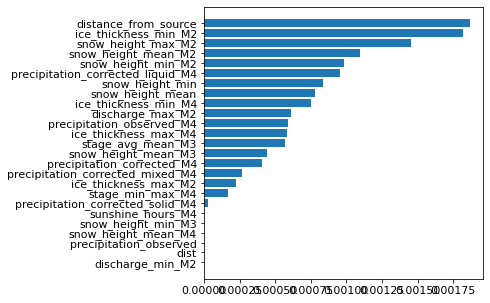

In [126]:
model.fit(X, y)
full_importance = model.named_steps['classifier'].feature_importances_  # # get importance

full_importance, X_cols = zip(*sorted(zip(full_importance, X.columns)))

pyplot.barh([x for x in X_cols[:25]], full_importance[:25])
pyplot.show()

### Разделим годы на train и test сбалансированно по суммарной продолжительности заторных событий

In [ ]:
# Суммарное количество заторов в году
jams_by_year = DATA_train.groupby('year').sum()['ice_jam'].to_frame().reset_index()
jams_by_year['ice_jam'].describe()

In [ ]:
# Разделим на бины по квартилям
bins = [-1, 3, 5, 8, 16]
jams_by_year['ice_jam_bins'] = pd.cut(jams_by_year['ice_jam'], bins)
X_length = jams_by_year[['year', 'ice_jam']]
y_length = jams_by_year['ice_jam_bins']
y_length.value_counts()

In [ ]:
# X_length

In [ ]:
# Разделим годы на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X_length, 
                                                    y_length, 
                                                    test_size=0.3,  
                                                    stratify=y_length, 
                                                    random_state=42)

### Соберем фичи из гидроданных

<div class="alert alert-block alert-warning">
Мы не можем использовать данные из будущего: всё, что происходит после заторного периода, относится уже к следующему году.
</div>

In [ ]:
# # # Внесем не темпоральные данные
# # DATA = pd.merge(DATA, hydro_coord[['hyd_station_id', 
# #                                 'distance_from_source', 
# #                                 'drainage_area', 
# #                                 'z_null']], on='hyd_station_id', how='left')

# # Возьмем также данные из ежедневных наблюдений
# hydro_1day = pd.read_csv(data_dir + 'hydro_1day.csv',
#                    parse_dates=['date'])
# hydro_1day.head(1)

In [ ]:
# hydro_1day['station_id'] = hydro_1day.station_id.astype(int)
# meteo_1day['station_id'] = meteo_1day['station_id'].astype(int)

In [ ]:
# meteo_1day.head()
# hydro_1day.head()

In [ ]:
# hydro_1day = hydro_1day.merge(meteo_1day, on=['station_id', 'year', 'month', 'day'], how='inner')
# hydro_1day = hydro_1day.fillna(0)
# hydro_1day.head()

### Скорректируем год, в который доступно наблюдение

In [ ]:
# # Определим для наблюдения год, в который оно доступно

# # Маска-окно между заторным периодом и концом года
# def after_jam_window(row, local=False):
#     if local:
#         month = row.month_local
#         day = row.date_local.day
#     else:
#         month = row.month
#         day = row.date.day
#     return (((month == 6) and (day > 3))
#             or (month in [7, 8, 9, 10, 11, 12]))

# # Год относительно бизнес-логики
# def target_year(row, local=False):
#     if local:
#         year = row.year_local
#     else:
#         year = row.year
#     if after_jam_window(row):
#         return year + 1
#     else:
#         return year
    
# # hydro_1day['target_year'] = hydro_1day.apply(target_year, axis=1)

# # # Календарный год и день больше не нужны
# # hydro_1day.drop(columns=['year', 'date', 'day'], axis=1, inplace=True)

# DATA['target_year'] = hydro_1day.apply(target_year, axis=1)
# DATA

In [ ]:
# Гидро – сделаем ресэмплинг по месяцу

index = ['station_id', 'month', 'target_year']

hydro_1day_mean = hydro_1day.groupby(index).mean().add_prefix('mean_').reset_index()
hydro_1day_max = hydro_1day.groupby(index).max().add_prefix('max_').reset_index()
hydro_1day_min = hydro_1day.groupby(index).min().add_prefix('min_').reset_index()
hydro_1day_std = hydro_1day.groupby(index).std().add_prefix('std_').reset_index()
data_frames = [hydro_1day_mean, hydro_1day_max, hydro_1day_min, hydro_1day_std]

hydro_monthly = pd.concat(data_frames, axis=1)
hydro_monthly = hydro_monthly.loc[:,~hydro_monthly.columns.duplicated()]
hydro_monthly.sort_values(index).head()

In [ ]:
def make_features(df):
    station, target_year = df.name
    result = pd.DataFrame()
    for month, mdf in df.groupby('month'):
        m_feats = mdf[df.columns[4:]].add_prefix(str(month) + '_').reset_index(drop=True)
        result = pd.concat([result, m_feats], axis=1)
    return result.reset_index(drop=True)
        
hydro_features = hydro_monthly.groupby(['station_id', 'target_year']).apply(make_features)
hydro_features = hydro_features.reset_index(level=2, drop=True).reset_index()
hydro_features.dropna(how='all', axis=1, inplace=True)
hydro_features

### Соберем фичи в основной датасет

<div class="alert alert-block alert-success">
Важно: merge делаем по target_year.
</div>

In [ ]:
DATA = pd.merge(DATA, hydro_features, left_on=['year', 'station_id'],
                   right_on=['target_year', 'station_id'],
                   how='left')
cols = DATA.columns.to_list()
DATA = DATA[cols[:3] + [cols[7]] + cols[5:7] + cols[8:] + [cols[3]]]
DATA.dropna(how='any',inplace=True)
DATA.head(2)

### Нормируем фичи

In [ ]:
from sklearn.preprocessing import StandardScaler

ids, data, target = DATA[DATA.columns[:4]], DATA[DATA.columns[4:-1]], DATA[DATA.columns[-1]]

scaler = StandardScaler()
scaler.fit(data)
transformed_data = scaler.transform(data)
norm_df = pd.concat([ids, pd.DataFrame(transformed_data, columns = DATA.columns[4:-1]), target], axis=1)
norm_df.sample()

In [ ]:
# Разделим на трейн и тест исходя из target_year

test = norm_df[~norm_df.target_year.isin(X_train.year.to_list())].reset_index(drop=True).dropna()
train = norm_df[norm_df.target_year.isin(X_train.year.to_list())].reset_index(drop=True).dropna()

# target_year больше не нужна

test.drop(columns=['target_year'], inplace=True)
train.drop(columns=['target_year'], inplace=True)

In [ ]:
# Поделим данные на предикторы и таргет

X_train, y_train = train.iloc[:, :-1], train.ice_jam
X_test, y_test = test.iloc[:, :-1], test.ice_jam

In [ ]:
#  discharge_mean_M4 дропаем

# Финальное разбиение фичей на группы

In [ ]:
# #Удаляем дубли

# clear_DATA = DATA[X_columns+y_columns].copy()

# print('До',clear_DATA.shape)
# clear_DATA.drop_duplicates(inplace=True)
# print('После', clear_DATA.shape)


# X = clear_DATA[X_columns]
# y = clear_DATA['MarkPercent']

# Обучение классификатора и подбор гиперпараметров

In [ ]:
# classifier = Pipeline(
#     steps=[
#     ("preprocessor", preprocessor),
#     ("classifier", RandomForestRegressor(n_jobs=-1, min_samples_split=3, max_depth=4, n_estimators=200, verbose=True))])

model = classifier  
parameters = {
    'classifier__min_samples_leaf':[11],
    'classifier__max_depth':[7],
    'classifier__n_estimators':[155], # 195
    'classifier__min_samples_split':[4]

}
grid = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring= 'neg_mean_squared_error')
grid.fit(X, y)

print("Лучшие параметры модели: ", grid.best_params_)

print('\n')
print("Метрика RMSE: ", abs(grid.best_score_)**0.5)

In [ ]:
model.fit(X, y)
full_importance = model.named_steps['classifier'].feature_importances_  # # get importance

full_importance, X_cols = zip(*sorted(zip(full_importance, X.columns)))

pyplot.barh([x for x in X_cols[:15]], full_importance[:15])
pyplot.show()

### Обучим простой классификатор

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
pca = PCA()
parameters = {'pca__n_components': list(range(400,500,50)), 'svc__kernel':('linear', 'rbf'), 'svc__C':[1,10]}
clf = Pipeline([('pca', pca), ('svc', SVC(class_weight='balanced'))])
GS = GridSearchCV(clf, parameters, scoring='f1_macro')
GS.fit(X_train, y_train)
print(GS.cv_results_)
print(GS.best_params_)

In [ ]:
prediction = GS.predict(X_test)
recall_score(y_test, prediction), \
    precision_score(y_test, prediction), f1_score(y_test, prediction)

In [ ]:
test = pd.read_csv(data_dir + 'test.csv')
#test_real = pd.read_csv(data_dir + '../test_SECRET.csv')

In [ ]:
test.day.unique()

In [ ]:
test_X = pd.merge(test_real, hydro_coord[['station_id', 
                                'distance_from_source', 
                                'drainage_area', 
                                'z_null']], on='station_id', how='left')

In [ ]:
'year' in hydro_features.columns

In [ ]:
test_X = pd.merge(test_X, hydro_features, left_on=['year', 'station_id'],
                   right_on=['target_year', 'station_id'],
                   how='left')
cols = test_X.columns.to_list()
test_X = test_X[cols[:3] + [cols[7]] + cols[5:7] + cols[8:] + [cols[3]]]

In [ ]:
ids, data, target = test_X[test_X.columns[:4]], test_X[test_X.columns[4:-1]], test_X[test_X.columns[-1]]

transformed_data = scaler.transform(data)
test_X = pd.concat([ids, pd.DataFrame(transformed_data, columns = DATA.columns[4:-1]), target], axis=1)
X_test_real, y_test_real = test_X.iloc[:, :-1], test_X.ice_jam

In [ ]:
X_test_real.drop('target_year',inplace=True,axis=1)
X_test_real = X_test_real.fillna(0)

In [ ]:
#X_test_real_reduced = selector.transform(X_test_real)
prediction =  GS.predict(X_test_real)
accuracy_score(y_test_real, prediction), recall_score(y_test_real, prediction), \
    precision_score(y_test_real, prediction), f1_score(y_test_real, prediction)